# LabelModel API

`modelbase 1.0` changes to way dynamic LabelModels are written and introduces the new LinearLabelModel, which calculates the relative label distribution of a system that is in steady state (and thus requires input of the steady state concentrations and fluxes).

Since LabelModels are not only applicable to carbon labeling problems, any reference of the word carbon was changed to label. Throughout this notebook we will use| a very small toy model which consists only of the triose phosphate isomerase and aldolase reactions.

In [1]:
import matplotlib.pyplot as plt

from modelbase.ode import Model, LabelModel, LinearLabelModel, Simulator
from modelbase.ode import ratefunctions as rf

Could not find GLIMDA.


In [2]:
# We will use the same parameters and initial concentrations for all models

p = {
    "kf_TPI": 1.0,
    "Keq_TPI": 21.0,
    "kf_Ald": 2000.0,
    "Keq_Ald": 7000.0,
}

p["kr_TPI"] = p["kf_TPI"] / p["Keq_TPI"]
p["kr_Ald"] = p["kf_Ald"] / p["Keq_Ald"]


# Generate initial concentrations
GAP0 = 2.5e-5
DHAP0 = GAP0 * p["Keq_TPI"]
FBP0 = GAP0 * DHAP0 * p["Keq_Ald"]

base_y0 = {"GAP": GAP0, "DHAP": DHAP0, "FBP": FBP0}

## Old-style Label model definition

One way of creating the model is by directly creating a LabelModel. We will see shortly that there are alternatives to this constructor for the common use case, but this constructor still has its validity.

In [3]:
lm = LabelModel(p)
lm.add_label_compounds({"GAP": 3, "DHAP": 3, "FBP": 6})
lm.add_labelmap_reaction(
    rate_name="TPIf",
    function=rf.mass_action_1,
    stoichiometry={"GAP": -1, "DHAP": 1},
    labelmap=[2, 1, 0],
    parameters=["kf_TPI"],
    reversible=False,
)
lm.add_labelmap_reaction(
    rate_name="TPIr",
    function=rf.mass_action_1,
    stoichiometry={"DHAP": -1, "GAP": 1},
    labelmap=[2, 1, 0],
    parameters=["kr_TPI"],
    reversible=False,
)
lm.add_labelmap_reaction(
    rate_name="ALDf",
    function=rf.mass_action_2,
    stoichiometry={"DHAP": -1, "GAP": -1, "FBP": 1},
    labelmap=[0, 1, 2, 3, 4, 5],
    parameters=["kf_Ald"],
    reversible=False,
)
lm.add_labelmap_reaction(
    rate_name="ALDr",
    function=rf.mass_action_1,
    labelmap=[0, 1, 2, 3, 4, 5],
    stoichiometry={"FBP": -1, "DHAP": 1, "GAP": 1,},
    parameters=["kr_Ald"],
    reversible=False,
)

# Simulate
y0 = lm.generate_y0(base_y0, label_positions={"GAP": 0})
s = Simulator(lm)
s.initialise(y0)
t, y = s.simulate(20)
fig, ax = s.plot_label_distribution_grid(
    ["GAP", "DHAP", "FBP"], sharey=False, relative=True, xlabels="Time [au]"
)
plt.show()

## Reversible Model definition

It is now possible to create LabelModels with reversible reactions as well, which drastically reduces the amount of code and code repetition. Do beware however, that swapping between LabelModels and LinearLabelModels in that case is not possible, because the latter requires that forward and backward reactions are split. 

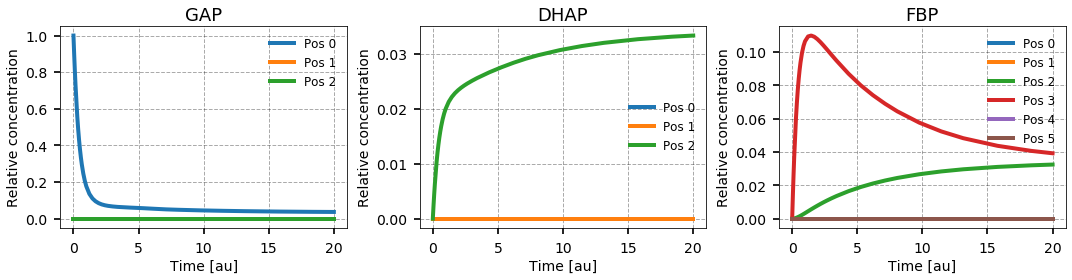

In [4]:
lm = LabelModel(p)
lm.add_label_compounds({"GAP": 3, "DHAP": 3, "FBP": 6})
lm.add_labelmap_reaction(
    rate_name="TPI",
    function=rf.reversible_mass_action_1_1,
    stoichiometry={"GAP": -1, "DHAP": 1},
    labelmap=[2, 1, 0],
    parameters=["kf_TPI", "kr_TPI"],
    reversible=True,
)
lm.add_labelmap_reaction(
    rate_name="ALD",
    function=rf.reversible_mass_action_2_1,
    stoichiometry={"DHAP": -1, "GAP": -1, "FBP": 1},
    labelmap=[0, 1, 2, 3, 4, 5],
    parameters=["kf_Ald", "kr_Ald"],
    reversible=True,
)

# Simulate
y0 = lm.generate_y0(base_y0, label_positions={"GAP": 0})
s = Simulator(lm)
s.initialise(y0)
t, y = s.simulate(20)
fig, ax = s.plot_label_distribution_grid(
    ["GAP", "DHAP", "FBP"], sharey=False, relative=True, xlabels="Time [au]"
)
plt.show()

## Creating LabelModels from Model

Since in both cases chances are that you have already a functioning Model of whatever LabelModel you are going to build, `modelbase 1.0` introduces conversion functions between different model types.

In [5]:
# Build the unlabeled model

m = Model(p)
m.add_compounds(["GAP", "DHAP", "FBP"])
m.add_reaction(
    rate_name="TPIf",
    function=rf.mass_action_1,
    stoichiometry={"GAP": -1, "DHAP": 1},
    parameters=["kf_TPI"],
    reversible=False,
)
m.add_reaction(
    rate_name="TPIr",
    function=rf.mass_action_1,
    stoichiometry={"DHAP": -1, "GAP": 1},
    parameters=["kr_TPI"],
    reversible=False,
)
m.add_reaction(
    rate_name="ALDf",
    function=rf.mass_action_2,
    stoichiometry={"DHAP": -1, "GAP": -1, "FBP": 1},
    parameters=["kf_Ald"],
    reversible=False,
)
m.add_reaction(
    rate_name="ALDr",
    function=rf.mass_action_1,
    stoichiometry={"FBP": -1, "DHAP": 1, "GAP": 1,},
    parameters=["kr_Ald"],
    reversible=False,
)

# Simulate
s = Simulator(m)
s.initialise(base_y0)
t, y = s.simulate(20)
s.plot()
plt.show()

### Creating the LabelModel

In [6]:
lm = m.to_labelmodel(
    labelcompounds={"GAP": 3, "DHAP": 3, "FBP": 6},
    labelmaps={
        "TPIf": [2, 1, 0],
        "TPIr": [2, 1, 0],
        "ALDf": [0, 1, 2, 3, 4, 5],
        "ALDr": [0, 1, 2, 3, 4, 5],
    },
)


# Simulate
y0 = lm.generate_y0(base_y0, label_positions={"GAP": 0})
ls = Simulator(lm)
ls.initialise(y0)
t, y = ls.simulate(20)
fig, ax = ls.plot_label_distribution_grid(
    ["GAP", "DHAP", "FBP"], ncols=3, sharey=False, relative=True, xlabels="Time [au]"
)
plt.show()

### Creating the LinearLabelModel

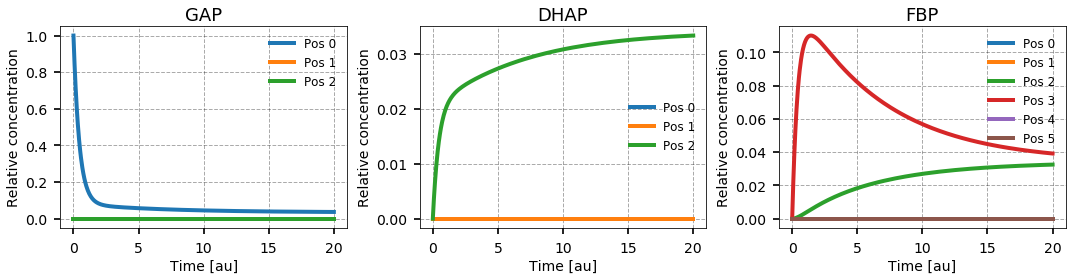

In [8]:
y_ss = base_y0
v_ss = {k: v[0] for k, v in m.get_fluxes_dict(y_ss).items()}

llm = m.to_linear_labelmodel(
    labelcompounds={"GAP": 3, "DHAP": 3, "FBP": 6},
    labelmaps={
        "TPIf": [2, 1, 0],
        "TPIr": [2, 1, 0],
        "ALDf": [0, 1, 2, 3, 4, 5],
        "ALDr": [0, 1, 2, 3, 4, 5],
    },
)

# Simulate
y0 = llm.generate_y0(initial_labels={"GAP": 0})
lls = Simulator(llm)
lls.initialise(y0, y_ss, v_ss)
t, y = lls.simulate(20)
fig, ax = lls.plot_label_distribution_grid(
    ["GAP", "DHAP", "FBP"], ncols=3, sharey=False, xlabels="Time [au]"
)
plt.show()